In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)
grid

Grid(origin=Point(coordinates=(13.920000000000002, 50.965999999999994), type='Point'), col_widths=[5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.56597453966269, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.565974539662733, 5.565974539662676, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.565974539662676, 5.565974539662733, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.565974539662733, 5.565974539

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup drain boundary with two observations

In [6]:
from morpheus.project.types.boundaries.DrainObservation import DrainRawDataItem, \
  DrainObservation
from morpheus.project.types.boundaries.GeneralHeadObservation import ObservationId, GeneralHeadRawDataItem, \
  GeneralHeadObservation, Stage, Conductance
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection
from morpheus.project.types.soil_model import LayerId
from morpheus.project.types.boundaries.Boundary import DrainBoundary, GeneralHeadBoundary

layers_list = [LayerId.new()]

drain_east = DrainBoundary.from_geometry(
  name=BoundaryName('drain_east'),
  geometry=LineString([
    (13.92499, 50.966),
    (13.92499, 50.964),
  ]),
  grid=grid,
  affected_layers=[model.soil_model.layers[0].id],
  observations=[
    DrainObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92499, 50.966)),
      raw_data=[
        DrainRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(.75),
          conductance=Conductance.from_float(100),
        ),
        DrainRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(.75),
          conductance=Conductance.from_float(100),
        ),
      ]
    ),
    DrainObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92499, 50.964)),
      raw_data=[
        DrainRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(.5),
          conductance=Conductance.from_float(200),
        ),
        DrainRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(.5),
          conductance=Conductance.from_float(200),
        ),
      ]
    ),
  ]
)

general_head_west = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_west'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92004, 50.96599),
  ]),
  grid=grid,
  affected_layers=[model.soil_model.layers[0].id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92004, 50.96599)),
      raw_data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(1),
          conductance=Conductance.from_float(300),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(1),
          conductance=Conductance.from_float(300),
        ),
      ]
    ),
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92004, 50.96401)),
      raw_data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(1),
          conductance=Conductance.from_float(400),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(1),
          conductance=Conductance.from_float(400),
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(general_head_west)
boundary_collection.add_boundary(drain_east)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(drain_east.as_geojson()))
m.add_child(folium.GeoJson(drain_east.affected_cells.to_geojson(grid).as_geojson()))
for observation in drain_east.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.add_child(folium.GeoJson(general_head_west.as_geojson()))
m.add_child(folium.GeoJson(general_head_west.affected_cells.to_geojson(grid).as_geojson()))
for observation in general_head_west.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

In [7]:
drain_east.observations

[DrainObservation(observation_id=ObservationId(value='3ad36b62-2ba3-4e2c-b6ec-13a99ea3b214'), geometry=Point(coordinates=(13.92499, 50.966), type='Point'), raw_data=[DrainRawDataItem(date_time=StartDateTime(value=datetime.datetime(2019, 1, 1, 0, 0)), stage=Stage(value=0.75), conductance=Conductance(value=100)), DrainRawDataItem(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0)), stage=Stage(value=0.75), conductance=Conductance(value=100))]),
 DrainObservation(observation_id=ObservationId(value='b5698769-f2f8-49d5-a319-a14daf28eaeb'), geometry=Point(coordinates=(13.92499, 50.964), type='Point'), raw_data=[DrainRawDataItem(date_time=StartDateTime(value=datetime.datetime(2019, 1, 1, 0, 0)), stage=Stage(value=0.5), conductance=Conductance(value=200)), DrainRawDataItem(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0)), stage=Stage(value=0.5), conductance=Conductance(value=200))])]

In [8]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.GhbPackageMapper import \
  calculate_ghb_boundary_stress_period_data

result = calculate_ghb_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  soil_model=model.soil_model,
  ghb_boundary=general_head_west,
)
result.to_dict()

{0: [[0, 0, 0, 1.0, 300.5050289789967],
  [0, 1, 0, 1.0, 302.5251892522284],
  [0, 2, 0, 1.0, 304.54535126413674],
  [0, 3, 0, 1.0, 306.5655150157982],
  [0, 4, 0, 1.0, 308.5856805068539],
  [0, 5, 0, 1.0, 310.60584773730386],
  [0, 6, 0, 1.0, 312.62601670750695],
  [0, 7, 0, 1.0, 314.6461874167454],
  [0, 8, 0, 1.0, 316.66635986573704],
  [0, 9, 0, 1.0, 318.68653405412294],
  [0, 10, 0, 1.0, 320.70670998226194],
  [0, 11, 0, 1.0, 322.72688764979523],
  [0, 12, 0, 1.0, 324.7470670563639],
  [0, 13, 0, 1.0, 326.7672482030445],
  [0, 14, 0, 1.0, 328.7874310884017],
  [0, 15, 0, 1.0, 330.80761571422977],
  [0, 16, 0, 1.0, 332.8278020790932],
  [0, 17, 0, 1.0, 334.847990182992],
  [0, 18, 0, 1.0, 336.8681800270029],
  [0, 19, 0, 1.0, 338.88837161040794],
  [0, 20, 0, 1.0, 340.90856493284844],
  [0, 21, 0, 1.0, 342.9287599954009],
  [0, 22, 0, 1.0, 344.9489567969888],
  [0, 23, 0, 1.0, 346.9691553383298],
  [0, 24, 0, 1.0, 348.9893556187062],
  [0, 25, 0, 1.0, 351.0095576388357],
  [0, 26, 

In [9]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.DrnPackageMapper import \
  calculate_drn_boundary_stress_period_data

result = calculate_drn_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  soil_model=model.soil_model,
  drn_boundary=drain_east,
)
result.to_dict()

{0: [[0, 0, 99, 0.7475000532765921, 100.99997868936319],
  [0, 1, 99, 0.7425001566003594, 102.99993735985626],
  [0, 2, 99, 0.7375002556209023, 104.99989775163911],
  [0, 3, 99, 0.7325003503355562, 106.99985986577755],
  [0, 4, 99, 0.7275004407452093, 108.99982370191631],
  [0, 5, 99, 0.7225005268498615, 110.9997892600554],
  [0, 6, 99, 0.7175006086486249, 112.99975654055007],
  [0, 7, 99, 0.7125006861432756, 114.99972554268979],
  [0, 8, 99, 0.7075007593320373, 116.9996962671851],
  [0, 9, 99, 0.7025008282157982, 118.99966871368073],
  [0, 10, 99, 0.6975008927936701, 120.99964288253196],
  [0, 11, 99, 0.6925009530665412, 122.9996187733835],
  [0, 12, 99, 0.6875010090352998, 124.9995963858801],
  [0, 13, 99, 0.6825010606972811, 126.99957572108755],
  [0, 14, 99, 0.677501108056038, 128.9995567775848],
  [0, 15, 99, 0.6725011511071296, 130.99953955714815],
  [0, 16, 99, 0.6675011898541086, 132.99952405835657],
  [0, 17, 99, 0.6625012242969749, 134.99951028121004],
  [0, 18, 99, 0.6575012

## Calculate

In [10]:
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import Calculation

calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
calculation = Calculation.new(model=model, calculation_profile=calculation_profile)

In [11]:
calculation = Calculation.from_dict(calculation.to_dict())
calculation.calculation_id

CalculationId(value='ff640a0c-ad4a-4df9-82da-6d7a4b05940f')

In [12]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService

calculation_service = CalculationService.from_calculation(calculation)
calculation_service.calculate()

FloPy is using the following executable to run the model: ../../../../../../../src/backend/.venv/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: 52fd1bb2-6552-4be9-9401-24423a51b8c4.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/04/19 22:22:38

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/04/19 22:22:38
 Elapsed run time:  0.033 Seconds

  Normal termination of simulation


In [13]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['52fd1bb2-6552-4be9-9401-24423a51b8c4.dis', '52fd1bb2-6552-4be9-9401-24423a51b8c4.drn', '52fd1bb2-6552-4be9-9401-24423a51b8c4.ghb', '52fd1bb2-6552-4be9-9401-24423a51b8c4.list', '52fd1bb2-6552-4be9-9401-24423a51b8c4.lpf', '52fd1bb2-6552-4be9-9401-24423a51b8c4.nam', '52fd1bb2-6552-4be9-9401-24423a51b8c4.bas', '52fd1bb2-6552-4be9-9401-24423a51b8c4.oc', '52fd1bb2-6552-4be9-9401-24423a51b8c4.pcg', '52fd1bb2-6552-4be9-9401-24423a51b8c4.hds'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

In [14]:
head = calculation_service.read_head(0, 0)

In [15]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[1.0, 0.9959999918937683, 0.9919999837875366, 0.9890000224113464, 0.9850000143051147, 0.9810000061988831, 0.9769999980926514, 0.9739999771118164, 0.9700000286102295, 0.9660000205039978, 0.9620000123977661, 0.9589999914169312, 0.9549999833106995, 0.9509999752044678, 0.9470000267028809, 0.9440000057220459, 0.9399999976158142, 0.9359999895095825, 0.9319999814033508, 0.9290000200271606, 0.925000011920929, 0.9210000038146973, 0.9169999957084656, 0.9139999747276306, 0.9100000262260437, 0.906000018119812, 0.9020000100135803, 0.8989999890327454, 0.8949999809265137, 0.890999972820282, 0.8880000114440918, 0.8840000033378601, 0.8799999952316284, 0.8769999742507935, 0.8730000257492065, 0.8690000176429749, 0.8659999966621399, 0.8619999885559082, 0.8579999804496765, 0.8550000190734863, 0.8510000109672546, 0.8479999899864197, 0.843999981880188, 0.8410000205039978, 0.8370000123977661, 0.8330000042915344, 0.8299999833106995, 0.8259999752044678, 0.8230000138282776, 0.8190000057220459, 0.81599998474121

In [16]:
calculation_service.read_drawdown(0, 0)

[]

In [17]:
calculation_service.read_budget(0, False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'DRAINS_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 88.9888,
 'TOTAL_IN': 88.9888,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'DRAINS_OUT': -88.9949,
 'HEAD_DEP_BOUNDS_OUT': -0.0,
 'TOTAL_OUT': -88.9949,
 'IN-OUT': -0.0061035,
 'PERCENT_DISCREPANCY': -0.01,
 'tslen': 365.0}

In [18]:
calculation_service.read_budget(0, True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'DRAINS_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 0.2438,
 'TOTAL_IN': 0.2438,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'DRAINS_OUT': -0.2438,
 'HEAD_DEP_BOUNDS_OUT': -0.0,
 'TOTAL_OUT': -0.2438,
 'IN-OUT': -1.6719e-05,
 'PERCENT_DISCREPANCY': -0.01,
 'tslen': 365.0}

In [19]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['52fd1bb2-6552-4be9-9401-24423a51b8c4.dis', '52fd1bb2-6552-4be9-9401-24423a51b8c4.drn', '52fd1bb2-6552-4be9-9401-24423a51b8c4.ghb', '52fd1bb2-6552-4be9-9401-24423a51b8c4.list', '52fd1bb2-6552-4be9-9401-24423a51b8c4.lpf', '52fd1bb2-6552-4be9-9401-24423a51b8c4.nam', '52fd1bb2-6552-4be9-9401-24423a51b8c4.bas', '52fd1bb2-6552-4be9-9401-24423a51b8c4.oc', '52fd1bb2-6552-4be9-9401-24423a51b8c4.pcg', '52fd1bb2-6552-4be9-9401-24423a51b8c4.hds'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

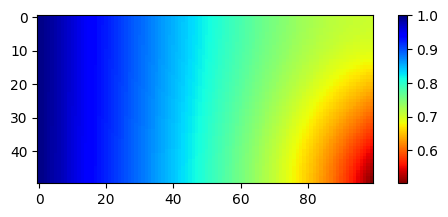

In [20]:
import matplotlib.pyplot as plt

heads = calculation_service.read_head(0, 0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()